In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import random
from tslearn.metrics import cdist_dtw
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy.signal import butter, filtfilt, resample, welch

from loadmydata.load_human_locomotion import (
    load_human_locomotion_dataset,
    get_code_list,
)


In [ ]:
# set all seeds
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
# parameters
fs = 100  # Hz

In [ ]:
subset_indexes_train = [95, 619, 441, 149, 951, 803, 214, 34, 37, 630]
subset_indexes_test = [683, 259, 59, 387, 634]

code_list = get_code_list()

X_train = list()  # list of footstep signals
y_train = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_train):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_train.append(signal[start:end])
        y_train.append(label)


X_test = list()  # list of footstep signals
y_test = list()  # list of pathologies (the "labels")

for code in np.take(code_list, subset_indexes_test):
    single_trial = load_human_locomotion_dataset(code)
    signal = (
        single_trial.signal.LAZ.to_numpy()
    )  # keeping only one dimension (from the left sensor)
    steps = single_trial.left_steps
    pathology = single_trial.metadata["PathologyGroup"]
    label = 0 if pathology == "Healthy" else 1  # 0: healthy, 1: non-healthy
    for start, end in steps:
        X_test.append(signal[start:end])
        y_test.append(label)

Train set: 168 steps
Test set:  88 steps


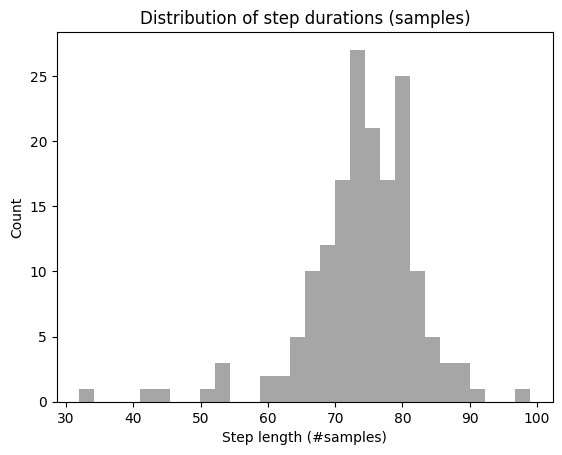

Mean length of footstep signals (train): 74
Std length of footstep signals (train): 8
Mean length of footstep signals (test): 81
Std length of footstep signals (test): 17


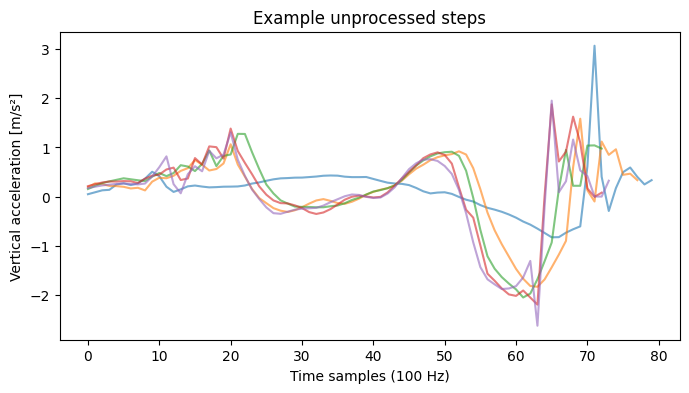

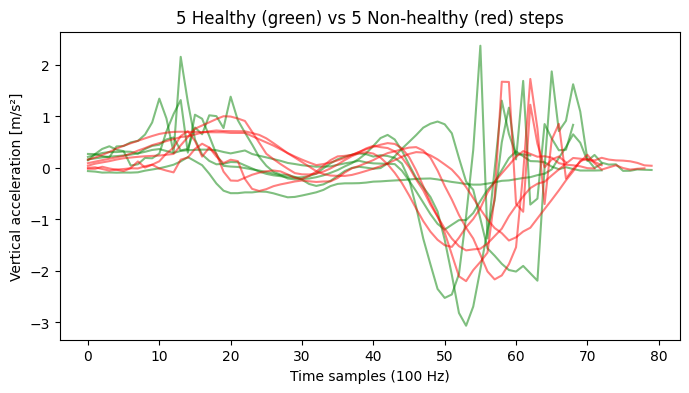

/Users/julesroyer/Code/.data-science-venv/lib/python3.12/site-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 80, using nperseg = 80
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


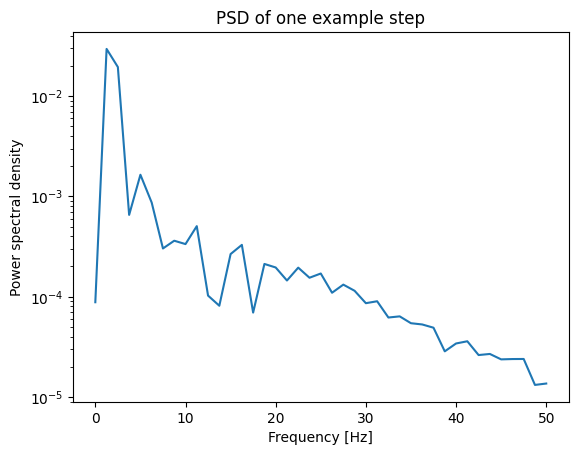

In [5]:
# basic infos
print(f"Train set: {len(X_train)} steps")
print(f"Test set:  {len(X_test)} steps")

# distribution of step lengths
train_lengths = [len(x) for x in X_train]
plt.hist(train_lengths, bins=30, color="gray", alpha=0.7)
plt.xlabel("Step length (#samples)")
plt.ylabel("Count")
plt.title("Distribution of step durations (samples)")
plt.show()

# mean and std of step lengths
mean_length_train = int(np.mean([len(x) for x in X_train]))
std_length_train = int(np.std([len(x) for x in X_train]))
mean_length_test = int(np.mean([len(x) for x in X_test]))
std_length_test = int(np.std([len(x) for x in X_test]))
print(f"Mean length of footstep signals (train): {mean_length_train}")
print(f"Std length of footstep signals (train): {std_length_train}")
print(f"Mean length of footstep signals (test): {mean_length_test}")
print(f"Std length of footstep signals (test): {std_length_test}")


# plot some steps
plt.figure(figsize=(8, 4))
for i, x in enumerate(X_train[:5]):
    plt.plot(x, alpha=0.6)
plt.title("Example unprocessed steps")
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot healthy vs non-healthy steps
healthy_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 0]
patho_steps = [X_train[i] for i in range(len(X_train)) if y_train[i] == 1]

plt.figure(figsize=(8, 4))
n_steps_to_plot = 5
for x in random.sample(healthy_steps, n_steps_to_plot):
    plt.plot(x, color="green", alpha=0.5)
for x in random.sample(patho_steps, n_steps_to_plot):
    plt.plot(x, color="red", alpha=0.5)
plt.title(
    f"{n_steps_to_plot} Healthy (green) vs {n_steps_to_plot} Non-healthy (red) steps"
)
plt.xlabel("Time samples (100 Hz)")
plt.ylabel("Vertical acceleration [m/s²]")
plt.show()

# plot psd of one example step
x = X_train[0]
f, Pxx = welch(x, fs=fs)
plt.semilogy(f, Pxx)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power spectral density")
plt.title("PSD of one example step")
plt.show()

In [6]:
# processing
def lowpass_filter(x, fs=100, cutoff=15, order=4):
    b, a = butter(order, cutoff / (fs / 2), btype="low")
    return filtfilt(b, a, x)


def preprocess_step(x, fs=100):
    # x = lowpass_filter(x, fs=fs, cutoff=15)  # denoise
    # x = x - np.mean(x)  # center
    # x = x / (np.std(x) + 1e-8)  # normalize
    # x = resample(x, mean_length_train)  # resample to mean train length
    print("no resampling applied")
    return x


def preprocess_dataset(X, fs=100):
    return [preprocess_step(x, fs=fs) for x in X]


# process datasets
X_train_proc = preprocess_dataset(X_train)
X_test_proc = preprocess_dataset(X_test)

# print(
#     f"After preprocessing, all steps have mean train length length: {len(X_train_proc[0])} samples"
# )

# convert labels to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampling applied
no resampl

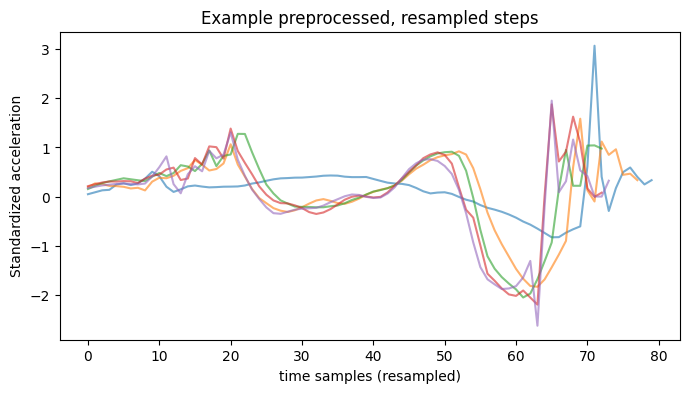

In [7]:
plt.figure(figsize=(8, 4))
for i in range(5):
    plt.plot(X_train_proc[i], alpha=0.6)
plt.title("Example preprocessed, resampled steps")
plt.xlabel("time samples (resampled)")
plt.ylabel("Standardized acceleration")
plt.show()

In [8]:
print("Computing DTW distance matrix (train–train)...")
D_train = cdist_dtw(X_train_proc)  # shape (N_train, N_train)

print("Computing DTW distance matrix (test–train)...")
D_test = cdist_dtw(X_test_proc, X_train_proc)  # shape (N_test, N_train)

In [9]:
k_values = [1, 3, 5, 7, 9, 11, 13, 15, 20, 30, 50, 70, 100]
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

best_k, best_f1 = None, 0
for k in k_values:
    fold_f1 = []
    for train_idx, val_idx in skf.split(D_train, y_train):
        D_tr = D_train[np.ix_(train_idx, train_idx)]
        D_val = D_train[np.ix_(val_idx, train_idx)]

        knn = KNeighborsClassifier(n_neighbors=k, metric="precomputed")
        knn.fit(D_tr, y_train[train_idx])
        y_pred = knn.predict(D_val)
        fold_f1.append(f1_score(y_train[val_idx], y_pred))

    mean_f1 = np.mean(fold_f1)
    print(f"k={k}: mean F1={mean_f1:.3f}")
    if mean_f1 > best_f1:
        best_f1, best_k = mean_f1, k

print(f"\nOptimal k={best_k}, mean CV-F1={best_f1:.3f}")

k=1: mean F1=0.898
k=3: mean F1=0.873
k=5: mean F1=0.859
k=7: mean F1=0.851
k=9: mean F1=0.849
k=11: mean F1=0.832
k=13: mean F1=0.819
k=15: mean F1=0.814
k=20: mean F1=0.798
k=30: mean F1=0.747
k=50: mean F1=0.651
k=70: mean F1=0.673
k=100: mean F1=0.618

Optimal k=1, mean CV-F1=0.898


In [10]:
knn_final = KNeighborsClassifier(n_neighbors=best_k, metric="precomputed")
knn_final.fit(D_train, y_train)
y_pred_test = knn_final.predict(D_test)

test_f1 = f1_score(y_test, y_pred_test)
print(f"Test F-score = {test_f1:.3f}")

Test F-score = 0.482


- no filter + no resample: 0.482
- filter + no resample: 0.396
- no filter + resample: 0.473
- filter + resample: 0.523


Question 11


In [11]:
# Predict and compute per-sample correctness
y_pred_test = knn_final.predict(D_test)
errors = y_pred_test != y_test

# Get indices of misclassified steps by true class
wrong_healthy = np.where((y_test == 0) & errors)[
    0
]  # true healthy misclassified as non-healthy
wrong_patho = np.where((y_test == 1) & errors)[
    0
]  # true non-healthy misclassified as healthy

In [12]:
import random

bad_h = random.choice(wrong_healthy) if len(wrong_healthy) > 0 else None
bad_p = random.choice(wrong_patho) if len(wrong_patho) > 0 else None

print("Misclassified healthy index:", bad_h)
print("Misclassified non-healthy index:", bad_p)

Misclassified healthy index: 44
Misclassified non-healthy index: 57


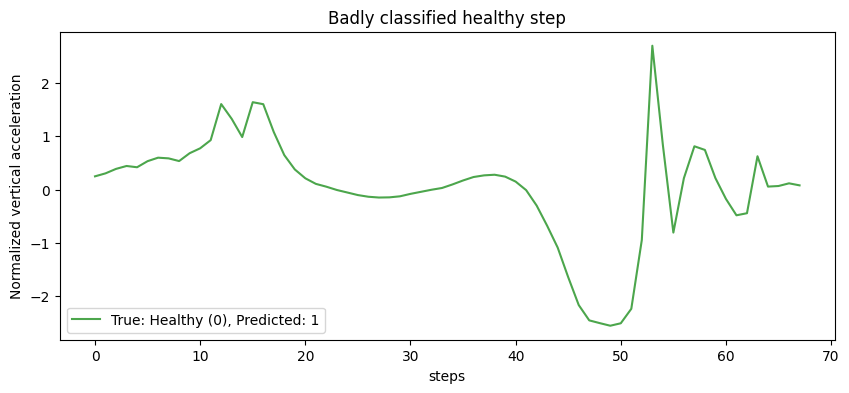

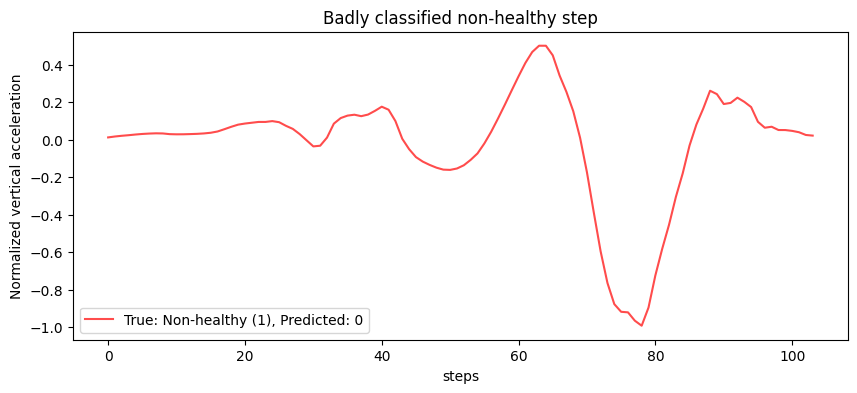

In [13]:
import matplotlib.pyplot as plt

# Misclassified healthy
plt.figure(figsize=(10, 4))
if bad_h is not None:
    plt.plot(
        X_test_proc[bad_h],
        color="green",
        alpha=0.7,
        label=f"True: Healthy (0), Predicted: {y_pred_test[bad_h]}",
    )
plt.xlabel("steps")
plt.ylabel("Normalized vertical acceleration")
plt.title("Badly classified healthy step")
plt.legend(loc="lower left")
plt.show()

# Misclassified non-healthy
plt.figure(figsize=(10, 4))
if bad_p is not None:
    plt.plot(
        X_test_proc[bad_p],
        color="red",
        alpha=0.7,
        label=f"True: Non-healthy (1), Predicted: {y_pred_test[bad_p]}",
    )
    plt.xlabel("steps")
plt.ylabel("Normalized vertical acceleration")
plt.title("Badly classified non-healthy step")
plt.legend(loc="lower left")
plt.show()